In [30]:
# Importing the libraries we will need throughout the code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


RANDOM_SEED = 42

### Importando os DataSets

No momento de construção das features, utilizamos dois computadores diferentes, e salvamos as features em dois arquivos separados (um na pasta Henry e um na pasta Vitor). Por isso, precisaremos juntar essas features em um dataframe único.

Além disso, uma série de features (informações sobre a Transformada de Fourrier) foram colhidas duas vezes. Por isso também se faz necessário remover uma série de informações.

##### Dataset de Treino

In [31]:
vitor_train = pd.read_csv('vitor/working.csv')
vitor_train = vitor_train.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
henry_train = pd.read_csv('henry/train_dataset.csv', header=1)
henry_train = henry_train.rename(columns={'Unnamed: 0': 'fpath'})
n_fpath_vitor = [fpath.replace('audio_train/audio_train/', '') for fpath in vitor_train.fpath]
vitor_train.fpath = n_fpath_vitor
columns_to_drop = ['1Q', '2Q', 'IQR', 'max', 'mean', 'median', 'min', 'std', 'tempo']
vitor_train = vitor_train.drop(columns_to_drop, axis=1)
henry_train = henry_train.drop(['filepath', 'label'], axis=1)

In [32]:
train = vitor_train.merge(henry_train, how='inner', on='fpath')

##### Dataset de Teste

In [33]:
vitor_test = pd.read_csv('vitor/test_info.csv')
vitor_test = vitor_test.drop(['Unnamed: 0'], axis=1)
henry_test = pd.read_csv('henry/test_dataset.csv', header=1)
henry_test = henry_test.rename(columns={'Unnamed: 0': 'fpath'})
n_fpath_vitor = [fpath.replace('../audio_test/', '') for fpath in vitor_test.fpath]
vitor_test.fpath = n_fpath_vitor
columns_to_drop = ['1Q', '2Q', 'IQR', 'max', 'mean', 'median', 'min', 'std', 'tempo']
vitor_test = vitor_test.drop(columns_to_drop, axis=1)
henry_test = henry_test.drop(['filepath', 'label'], axis=1)

In [34]:
test = vitor_test.merge(henry_test, how='inner', on='fpath')

### Features 

In [71]:
test.head(3)

,fpath,h1Q,h2Q,hIQR,hmax,hmean,hmedian,hmin,hstd,htempo,...,SContr_min,SContr_std,SF_1Q,SF_2Q,SF_IQR,SF_max,SF_mean,SF_median,SF_min,SF_std
0,00326aa9.wav,0.006032,0.035576,0.029545,7401.113420,1.322456,0.011697,0.000048,55.143729,161.499023,...,3.052424,10.408681,3.996415e-07,0.007290,0.007290,0.035315,0.004633,0.000043,3.251706e-07,0.006985
1,0038a046.wav,0.008532,0.051157,0.042625,324.037334,1.238900,0.015763,0.000062,13.658693,143.554688,...,2.013742,3.773490,6.232203e-04,0.201938,0.201314,0.497214,0.109013,0.028249,2.808092e-07,0.142343
2,007759c4.wav,0.090394,0.594547,0.504153,4828.572995,2.857105,0.217254,0.000619,50.367111,120.185320,...,2.768268,7.771623,2.650683e-05,0.000058,0.000032,0.024345,0.000480,0.000040,1.186926e-05,0.002464


In [35]:
features = train.drop(['label', 'fpath'], axis=1)
harmonic_features = features.loc[:, features.columns.str.contains('h')]
percussion_features = features.loc[:, features.columns.str.contains('p')].drop('htempo', axis=1)
short_furrier_features = features.loc[:, features.columns.str.contains('SF')]
furrier_features = features.loc[:, features.columns.str.contains('F')].drop(short_furrier_features.columns, axis=1)
sc_features = features.loc[:, features.columns.str.contains('SC_')]
scontr_features = features.loc[:, features.columns.str.contains('SContr_')]

##### Features da Transformada de Fourrier nas Harmônicas do Áudio

In [36]:
harmonic_features.describe()

,h1Q,h2Q,hIQR,hmax,hmean,hmedian,hmin,hstd,htempo
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,2.285788,11.765830,9.480041,2619.229788,14.055525,5.110358,0.010180,50.388575,138.137611
std,7.912372,39.039777,33.318640,7071.871671,32.163496,19.331109,0.042831,86.037541,31.802837
min,0.001221,0.003282,0.002062,0.160836,0.004886,0.002027,0.000003,0.007558,23.598031
25%,0.025458,0.243880,0.205723,134.674744,0.990574,0.071147,0.000134,4.686215,123.046875
50%,0.159787,1.285306,1.114600,592.515769,3.425645,0.422419,0.000758,18.110632,129.199219
75%,1.036348,6.878079,5.594942,2409.412218,12.542872,2.506443,0.004059,56.990626,139.674831
max,116.808253,1108.780672,1107.949349,195925.092642,662.546944,596.668020,1.030636,1180.335435,303.998162


##### Features da Transformada de Fourier nas Percussões do Áudio

In [37]:
percussion_features.describe()

,p1Q,p2Q,pIQR,pmax,pmean,pmedian,pmin,pstd,ptempo
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,4.359216,15.272841,10.913625,263.146923,12.701923,8.169464,0.026480,15.673715,141.623786
std,12.301142,36.387465,24.668795,620.849598,27.878304,21.561531,0.084419,27.408017,40.209930
min,0.001988,0.004899,0.002831,0.106350,0.004203,0.003127,0.000003,0.004180,23.598031
25%,0.093099,0.859102,0.703279,28.354058,1.239088,0.274267,0.000446,2.348618,120.185320
50%,0.592364,3.714990,3.013048,99.129714,3.772901,1.436124,0.002985,6.890336,129.199219
75%,3.039279,13.048500,9.795101,269.318013,11.506003,6.380578,0.016241,16.991519,147.656250
max,237.000946,574.107679,359.026528,10714.446591,447.442215,380.539397,1.885057,377.749889,303.998162


##### Features da Transformada Curta de Fourier

In [38]:
short_furrier_features.describe()

,SF_1Q,SF_2Q,SF_IQR,SF_max,SF_mean,SF_median,SF_min,SF_std
count,2.774000e+03,2.774000e+03,2.774000e+03,2774.000000,2.774000e+03,2.774000e+03,2.774000e+03,2774.000000
mean,1.480323e-02,6.422325e-02,4.942002e-02,0.237093,4.545938e-02,3.377064e-02,2.723128e-03,0.048135
std,4.887828e-02,1.185031e-01,9.868687e-02,0.179009,7.337304e-02,8.365655e-02,1.235728e-02,0.053721
min,2.473097e-09,4.565545e-09,3.635068e-10,0.000033,2.260838e-07,3.242665e-09,2.070149e-09,0.000003
25%,2.574683e-05,4.663606e-04,3.761954e-04,0.052403,2.250917e-03,9.136331e-05,3.378250e-06,0.006057
50%,3.841768e-04,6.402018e-03,5.090924e-03,0.229063,1.166389e-02,1.365362e-03,3.006935e-05,0.024899
75%,4.855565e-03,5.524477e-02,4.024616e-02,0.419031,5.259786e-02,1.650730e-02,3.486461e-04,0.072655
max,4.223041e-01,5.201777e-01,5.156225e-01,0.894080,3.797287e-01,4.429165e-01,2.185830e-01,0.244990


##### Features da Transformação de Fourier

In [39]:
furrier_features.describe()

,F_1Q,F_2Q,F_IQR,F_max,F_mean,F_median,F_min,F_std
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,6.450801,25.499821,19.049020,2764.928951,24.977622,12.732376,0.037166,60.316987
std,19.056088,64.913186,48.271359,7172.245206,51.360194,36.134103,0.142850,93.140212
min,0.004089,0.009744,0.005655,3.253576,0.011008,0.006538,0.000005,0.056864
25%,0.125576,1.325937,1.101026,213.977188,2.971119,0.399696,0.000579,10.151932
50%,0.821603,5.652430,4.571165,736.539020,7.967526,2.106444,0.003424,26.232633
75%,4.366011,20.865706,15.765206,2582.751650,23.928196,9.358247,0.019638,68.458194
max,360.737411,1116.513367,1113.442722,195929.000000,814.454500,613.572000,3.226510,1180.256700


##### Features da SC

In [40]:
sc_features.describe()

,SC_1Q,SC_2Q,SC_IQR,SC_max,SC_mean,SC_median,SC_min,SC_std
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,3005.465545,4992.245558,1986.780013,8756.947746,4108.785902,3854.970250,1834.633473,1556.417318
std,2372.093447,3170.335634,2066.337882,2969.762396,2483.382056,2795.738610,1783.495203,1006.725465
min,62.269864,76.870900,0.322563,683.601855,152.505111,65.678269,24.563503,20.553111
25%,1338.107583,2359.215391,559.890198,6591.511353,2191.087213,1703.931276,739.166364,790.535486
50%,2250.158780,4134.770539,1286.252436,9634.735188,3489.675364,3004.919771,1292.959800,1320.085254
75%,3917.527077,7314.328609,2613.334236,10929.770137,5525.019395,5342.083903,2196.473953,2139.830915
max,12492.723939,14326.531494,13805.516295,19233.674336,12753.692247,12999.260898,10732.331593,6326.939343


##### Features da SContr

In [41]:
scontr_features.describe()

,SContr_1Q,SContr_2Q,SContr_IQR,SContr_max,SContr_mean,SContr_median,SContr_min,SContr_std
count,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000,2774.000000
mean,12.256690,20.591157,8.334467,41.618051,16.852889,16.200758,2.455836,6.529174
std,2.617792,5.373726,3.857872,7.814738,3.573181,4.023351,1.129314,2.044740
min,2.112598,13.633414,2.886049,23.645745,11.542362,7.368868,0.043776,3.142344
25%,10.431000,16.425292,5.752351,35.476651,14.116775,13.415033,1.721968,4.959946
50%,11.457435,18.671038,7.004061,41.508618,15.666576,14.411687,2.360097,6.011654
75%,13.292176,23.594802,9.714950,47.037271,18.797064,17.831150,3.074486,7.797841
max,25.846894,53.644785,41.752944,70.498373,31.852773,35.124084,8.575364,20.521009


##### Correlação entre os grupos de features

<p style='font-size:12px; font-weight:bold'>Transformada de Fourier vs SC</p>

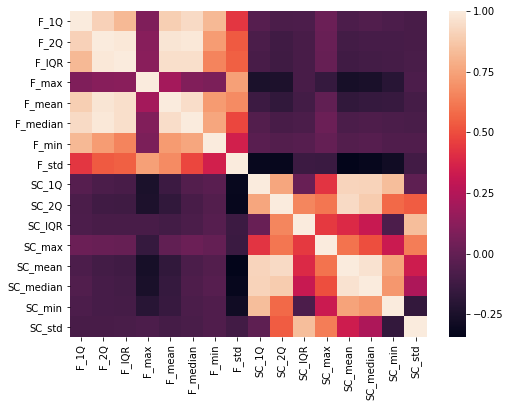

In [43]:
fsc = pd.concat([furrier_features, sc_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(fsc.corr())
plt.show()

<p style='font-size:12px; font-weight:bold'>Transformada de Fourier vs SContr</p>

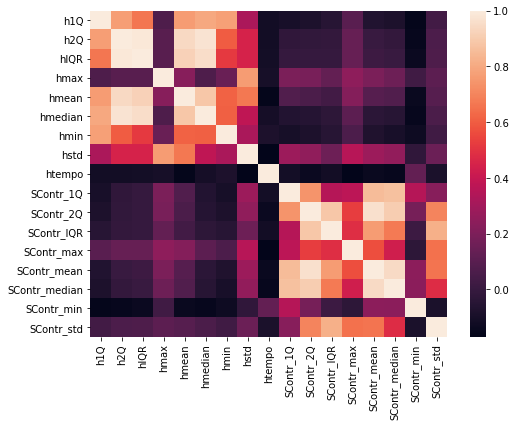

In [45]:
fscon = pd.concat([harmonic_features, scontr_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(fscon.corr())
plt.show()

<p style='font-size:12px; font-weight:bold'>Transformada de Fourier Da Percussão vs SC</p>

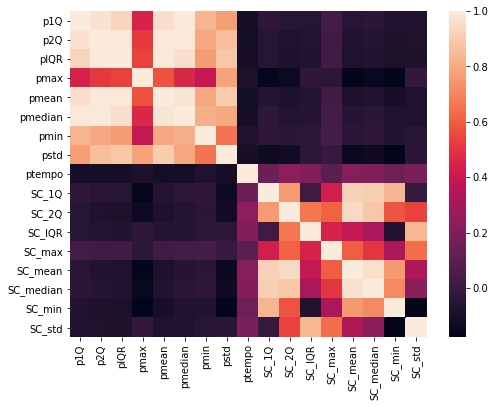

In [46]:
psc = pd.concat([percussion_features, sc_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(psc.corr())
plt.show()

<p style='font-size:12px; font-weight:bold'>Transformada de Fourier Da Percussão vs SContr</p>

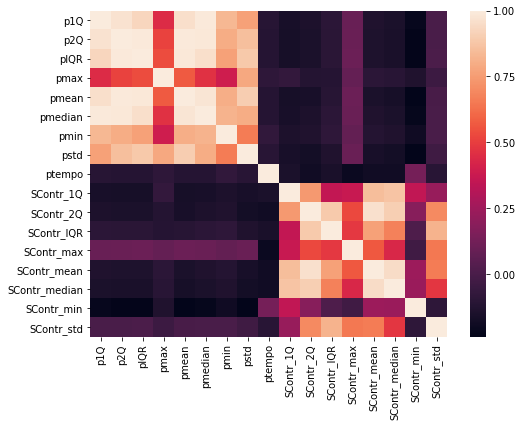

In [47]:
pscon = pd.concat([percussion_features, scontr_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(pscon.corr())
plt.show()

<p style='font-size:12px; font-weight:bold'>Transformada de Fourier Da Harmonica vs SC</p>

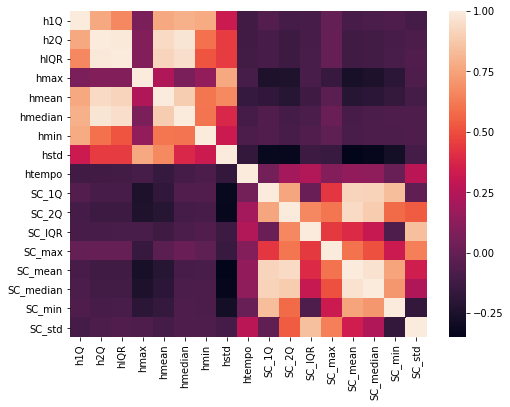

In [48]:
hsc = pd.concat([harmonic_features, sc_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(hsc.corr())
plt.show()

<p style='font-size:12px; font-weight:bold'>Transformada de Fourier Da Harmonica vs SContr</p>

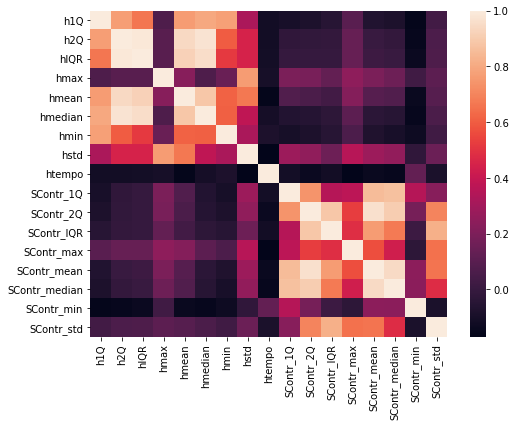

In [49]:
hscon = pd.concat([harmonic_features, scontr_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(hscon.corr())
plt.show()

<p style='font-size:12px; font-weight:bold'>Scontr vs SC</p>

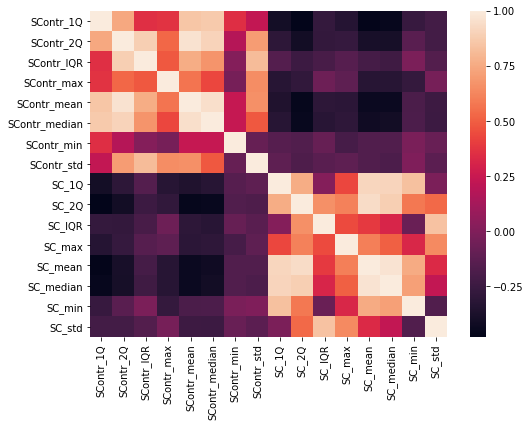

In [50]:
sconsc = pd.concat([scontr_features, sc_features], axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(sconsc.corr())
plt.show()

### Modelo Iniciais

In [51]:
columns_on_df = list(test.columns)
x_columns = columns_on_df
x_columns.remove('fpath')
x_columns.remove('label')

In [52]:
# Getting Train and Test data
x_train = train[x_columns]
y_train = train['label']
x_test = test[x_columns]
y_test = test['label']

In [53]:
# Feature Scalling the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [64]:
from sklearn.model_selection import cross_val_score
range_list = list(range(1,50))


def odd(list_n):
    list_odd = []
    for number in list_n:
        x = number % 2
        if x > 0:
            list_odd.append(x)
        return list_odd
        

neighbors = odd(range_list)

#neighbors = filter(lambda x: x % 2 != 0, range_list)



cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

    
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]

In [65]:
# Creating our Models
knn_model = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
#rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
#gb_model = GradientBoostingClassifier(random_state=RANDOM_SEED)

In [66]:
# Fitting the Models
knn_model.fit(x_train, y_train)
#rf_model.fit(x_train, y_train)
#gb_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='distance')

In [67]:
# Predicting the Categories
y_knn = knn_model.predict(x_test)
#y_rf = rf_model.predict(x_test)
#y_gb = gb_model.predict(x_test)

In [68]:
# Getting Accuracy
knn_acc = acc(y_test, y_knn)
#rf_acc = acc(y_test, y_rf)
#gb_acc = acc(y_test, y_gb)

In [69]:
knn_acc#, rf_acc, gb_acc

0.366875

#### Improving the Model

##### Feature Selection